# 02_spread_backtest.ipynb  
**Objective:**  
- Load cointegrated pairs and aligned prices  
- Define spreads & Z-scores, generate long/short signals  
- Perform a daily backtest loop with transaction costs, track P&L  


In [2]:
# 1. Imports & Data
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the aligned prices
prices = pd.read_csv("../data/processed/aligned_prices2.csv",
                     index_col="Date", parse_dates=True)

# load cointegrated pairs
with open("../data/processed/cointegrated_pairs.json") as f:
    coint_pairs = json.load(f)
# each entry is {"A": str, "B": str, "beta": float}

# backtest parameters
entry_z   =  2.0     # entry threshold
exit_z    =  0.5     # exit threshold
cost_rate =  0.001   # 0.1% per leg
initial_capital = 100_000  # for scaling returns


In [3]:
# 2. Backtest function for one pair
def backtest_pair(prices, A, B, beta,
                  entry_z, exit_z, cost_rate):
    spread = prices[A] - beta * prices[B]
    mu, sigma = spread.mean(), spread.std()
    z = (spread - mu) / sigma

    dates = spread.index
    n = len(dates)

    # simulate daily positions:  1 = long spread, -1 = short spread, 0 = flat
    pos = np.zeros(n, dtype=int)
    for t in range(1, n):
        prev = pos[t-1]
        if prev == 0:
            if z[t] >  entry_z: pos[t] = -1
            elif z[t] < -entry_z: pos[t] = +1
        else:
            # exit when close to mean
            if abs(z[t]) < exit_z:
                pos[t] = 0
            else:
                pos[t] = prev

    # compute daily P&L from spread moves
    spread_diff = spread.diff().fillna(0).values
    # P&L per unit of spread
    pnl = pos[:-1] * spread_diff[1:]

    # transaction costs on entries/exits
    trades = np.where(pos[1:] != pos[:-1])[0] + 1
    costs = np.zeros(n)
    for t in trades:
        # cost = cost_rate * (|ΔA shares|*price_A + |ΔB shares|*price_B)
        # here 1 spread‐unit uses 1 share of A, beta of B
        costs[t] = cost_rate * ( prices[A].iloc[t] + beta * prices[B].iloc[t] )

    # net P&L
    pnl_net = pnl - costs[1:]
    cum_pnl = np.cumsum(pnl_net)

    # scale to capital: assume 1 spread‐unit ≈ $1 notional, scale to initial_capital
    factor = initial_capital / (prices[A].mean() + beta*prices[B].mean())
    cum_return = cum_pnl * factor / initial_capital

    return pd.DataFrame({
        "Spread": spread,
        "Z": z,
        "Position": pos,
        "PnL_net": np.concatenate([[0], pnl_net]),
        "CumPnL": np.concatenate([[0], cum_pnl]),
        "CumReturn": np.concatenate([[0], cum_return]),
        "Cost": costs
    }, index=dates)


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair ATO-KMI (β=3.39):
  Trades: 8, Total P&L $28, Return 16.54%
  Sharpe ≈ 1.24


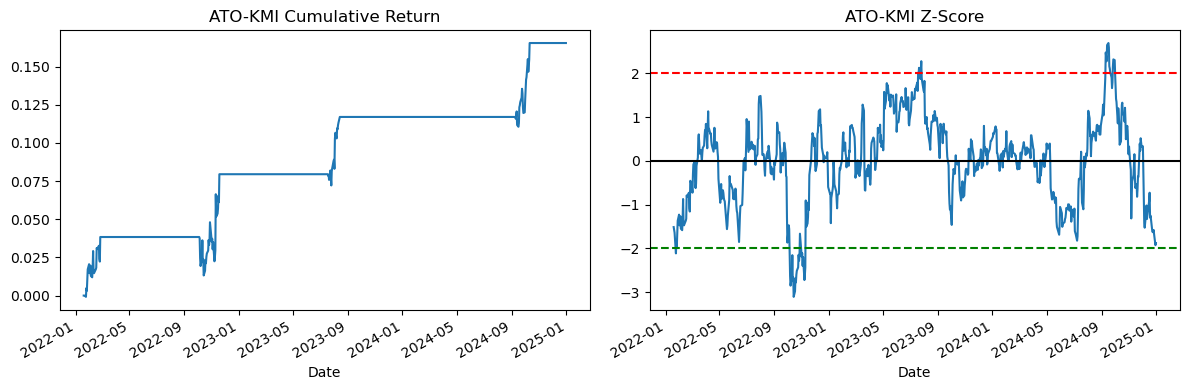

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair ATO-PEG (β=1.03):
  Trades: 8, Total P&L $32, Return 17.88%
  Sharpe ≈ 1.90


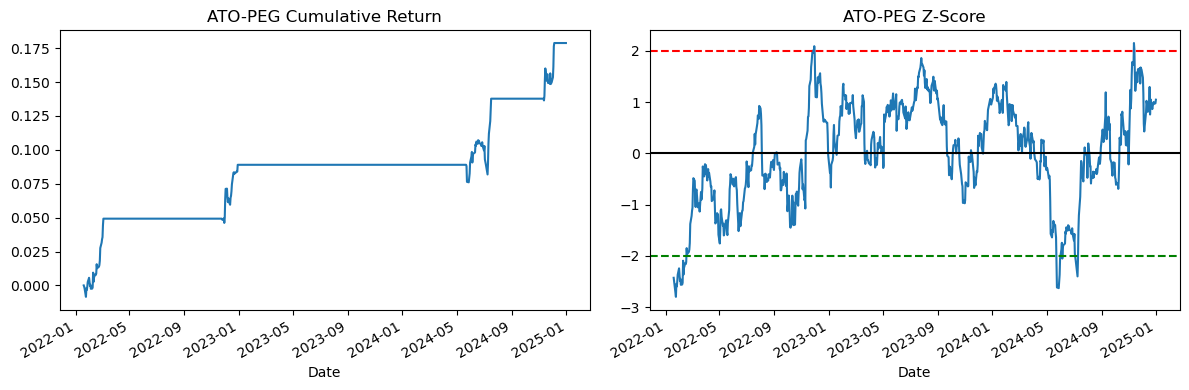

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair ATO-PPL (β=3.84):
  Trades: 6, Total P&L $30, Return 13.97%
  Sharpe ≈ 1.77


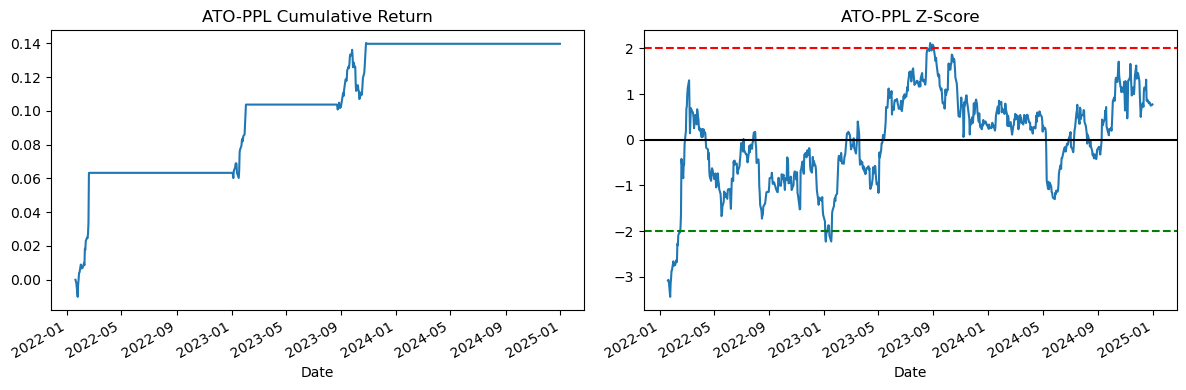

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair ATO-VST (β=0.27):
  Trades: 10, Total P&L $49, Return 39.58%
  Sharpe ≈ 1.58


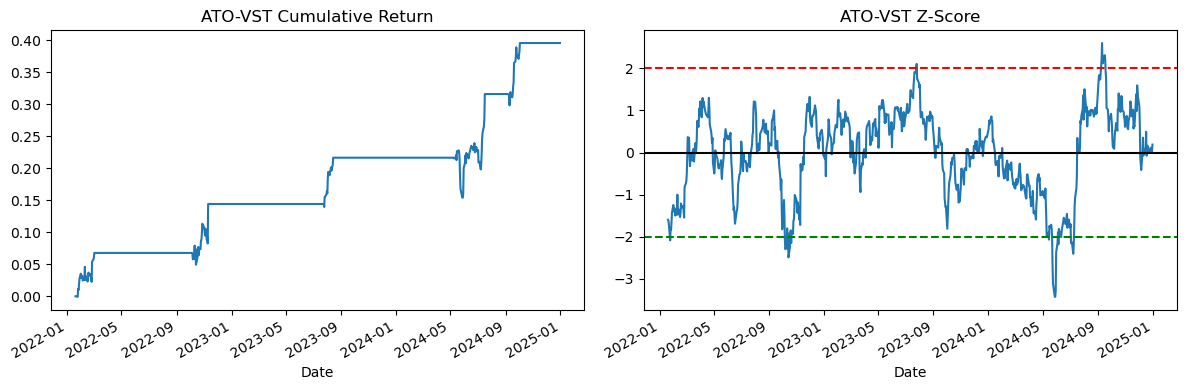

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair ATO-WMB (β=1.35):
  Trades: 10, Total P&L $41, Return 25.92%
  Sharpe ≈ 1.45


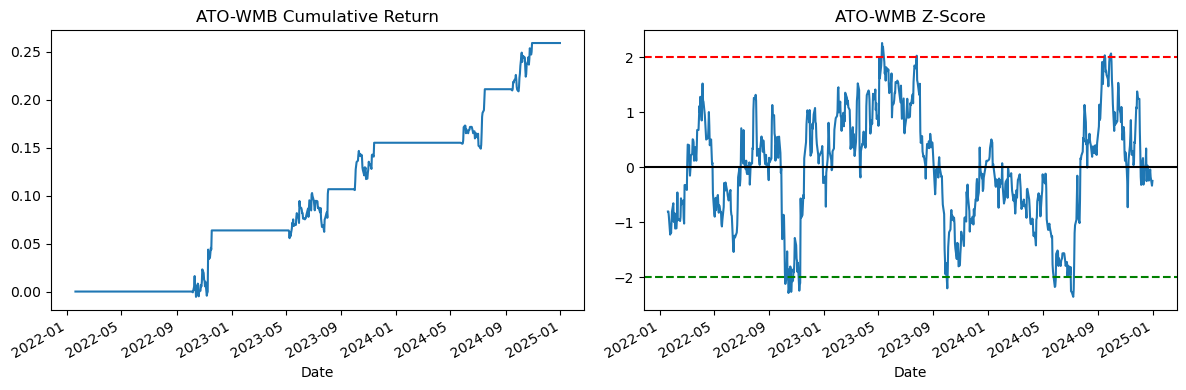

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CEG-NRG (β=2.92):
  Trades: 4, Total P&L $76, Return 28.52%
  Sharpe ≈ 0.92


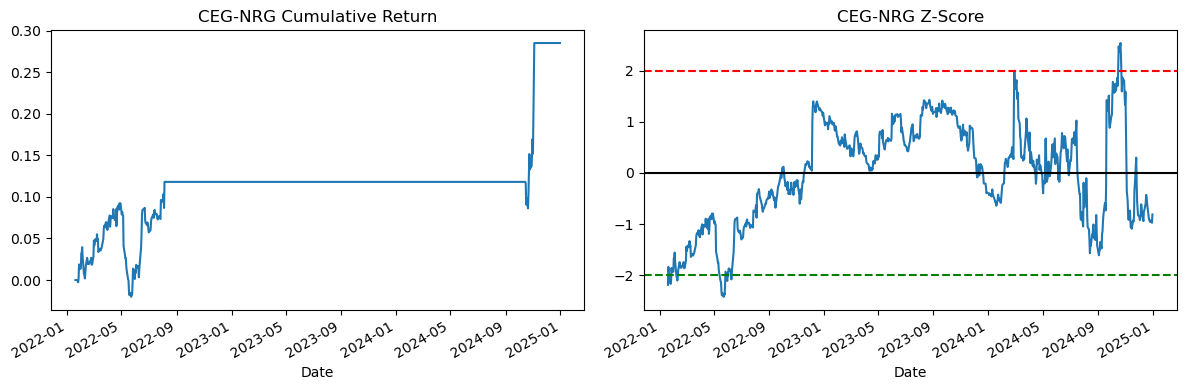

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CMS-SLB (β=-0.39):
  Trades: 3, Total P&L $11, Return 25.74%
  Sharpe ≈ 0.68


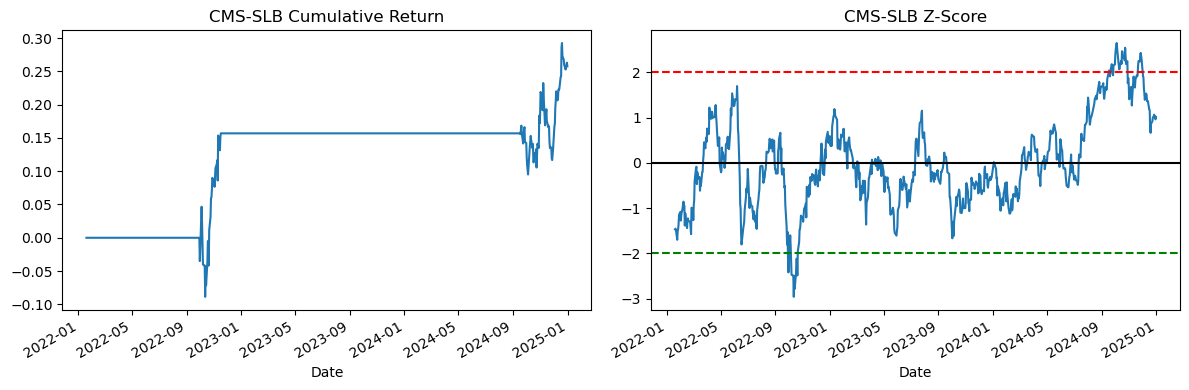

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-DTE (β=0.11):
  Trades: 7, Total P&L $7, Return 18.80%
  Sharpe ≈ 1.21


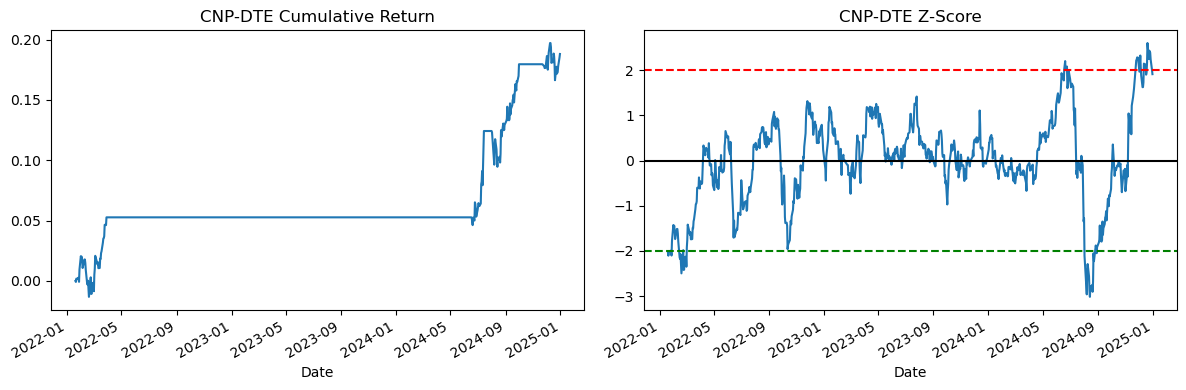

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-DUK (β=0.10):
  Trades: 5, Total P&L $5, Return 13.41%
  Sharpe ≈ 1.04


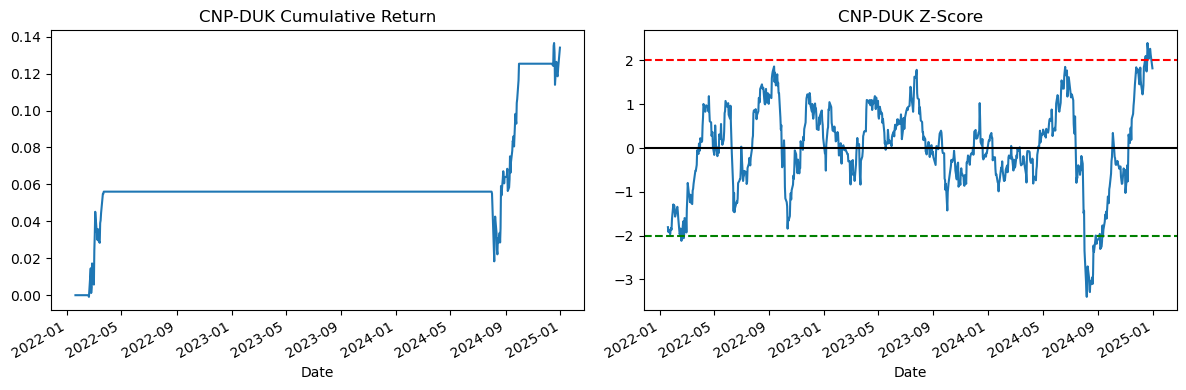


Pair CNP-EPAM (β=-0.00):
  Trades: 9, Total P&L $11, Return 40.88%
  Sharpe ≈ 1.64


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

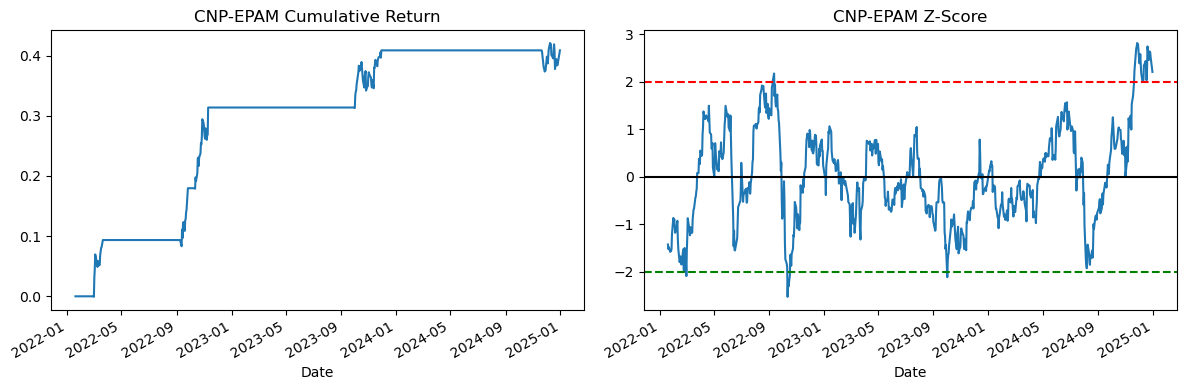

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-ETR (β=0.15):
  Trades: 10, Total P&L $11, Return 31.04%
  Sharpe ≈ 1.58


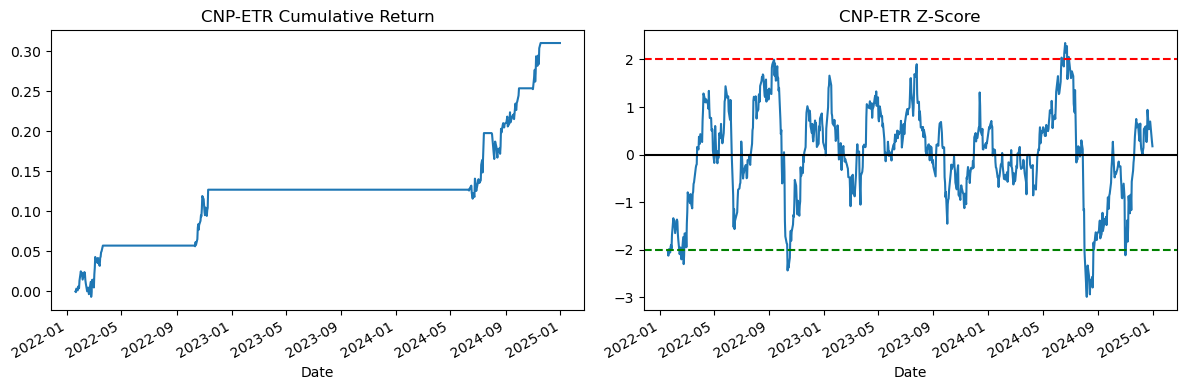

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-HAL (β=-0.06):
  Trades: 5, Total P&L $6, Return 22.77%
  Sharpe ≈ 0.93


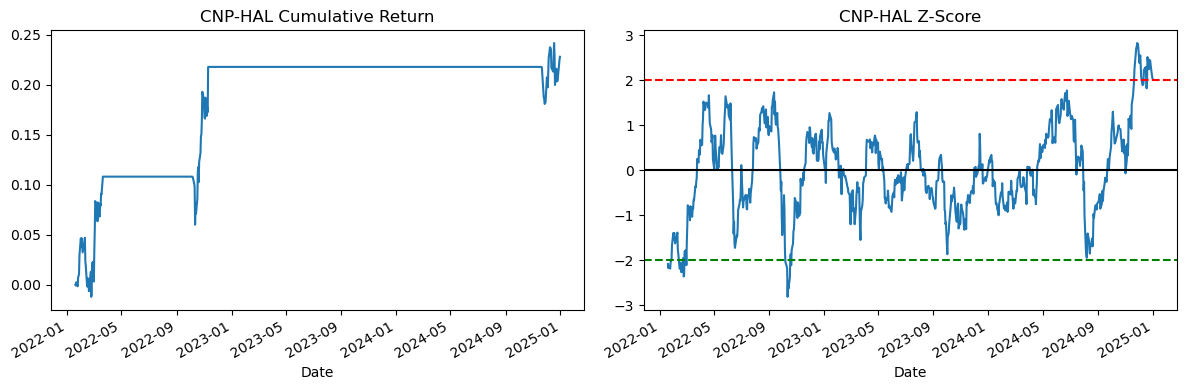

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-KMI (β=0.28):
  Trades: 6, Total P&L $8, Return 25.37%
  Sharpe ≈ 1.53


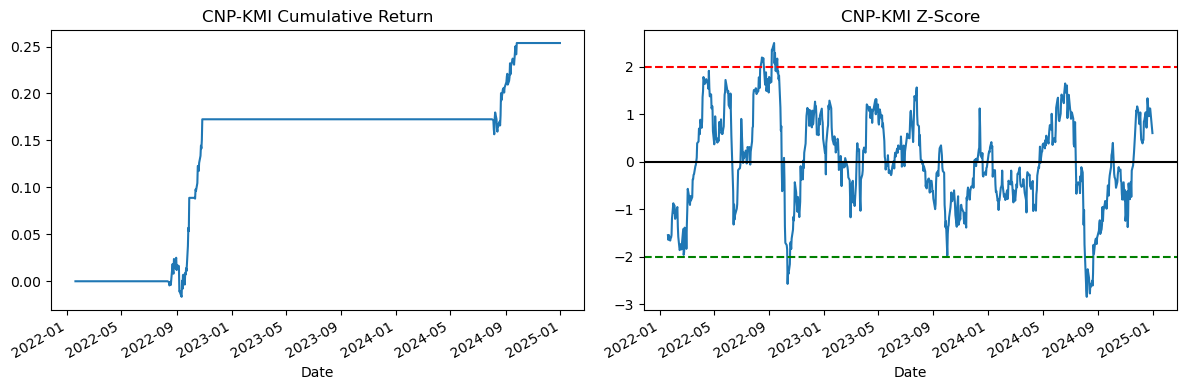

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-NRG (β=0.03):
  Trades: 9, Total P&L $11, Return 38.29%
  Sharpe ≈ 1.81


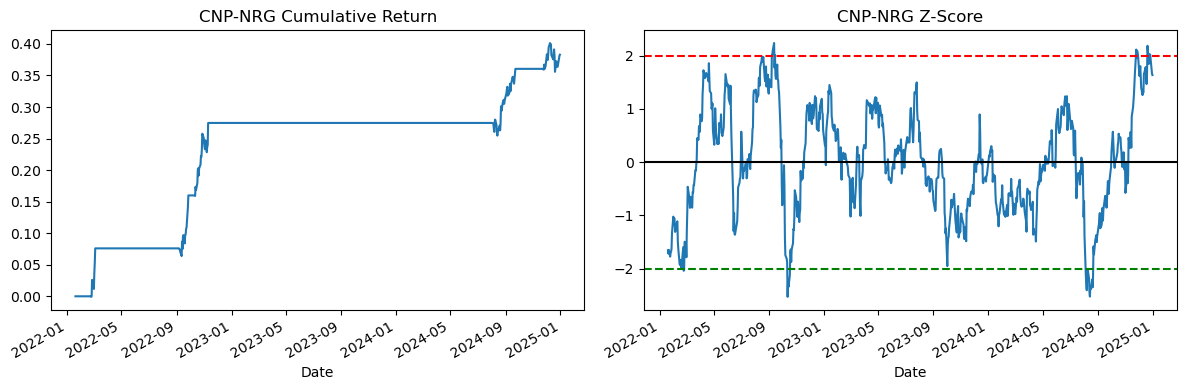


Pair CNP-PCG (β=0.16):
  Trades: 9, Total P&L $11, Return 37.92%
  Sharpe ≈ 1.69


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

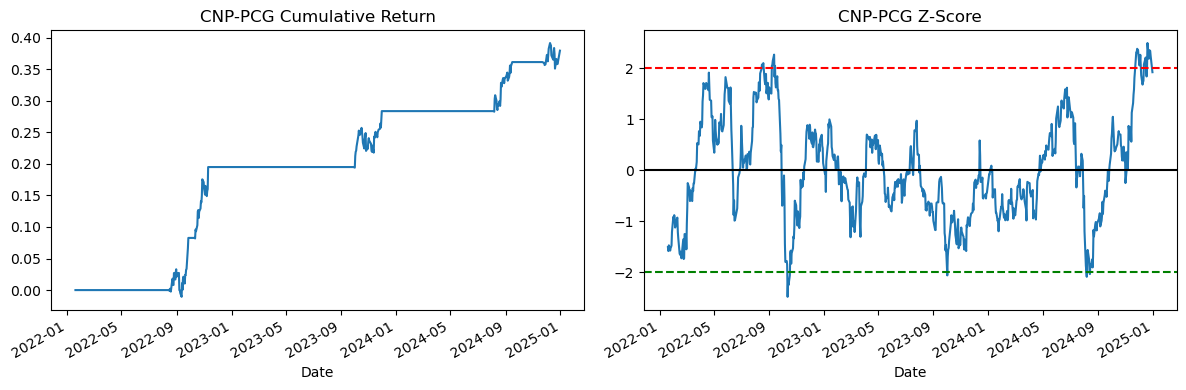

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-PEG (β=0.08):
  Trades: 8, Total P&L $10, Return 31.82%
  Sharpe ≈ 1.92


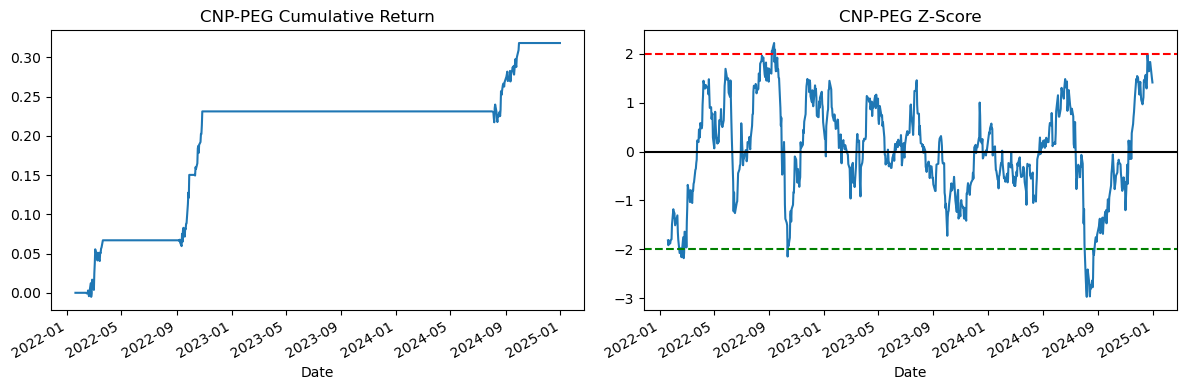

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-PNW (β=0.10):
  Trades: 7, Total P&L $8, Return 21.76%
  Sharpe ≈ 1.35


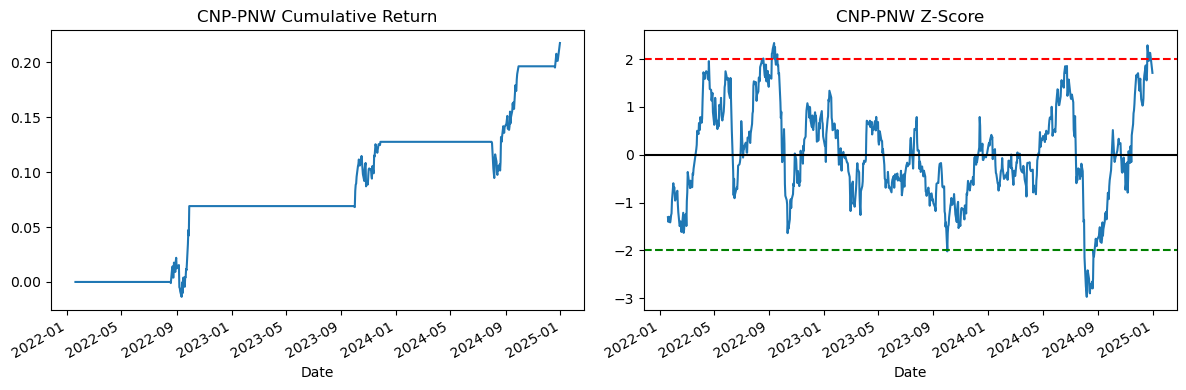

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-PPL (β=0.38):
  Trades: 6, Total P&L $7, Return 17.96%
  Sharpe ≈ 1.35


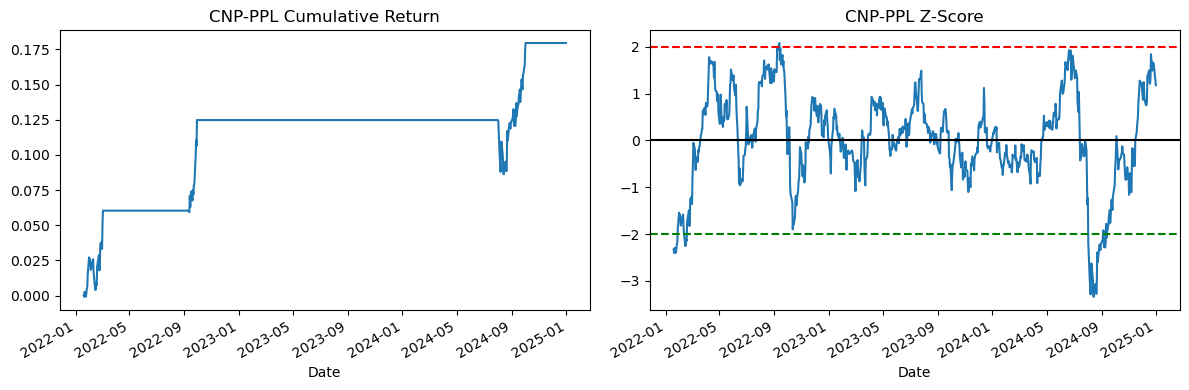

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-SLB (β=-0.05):
  Trades: 5, Total P&L $5, Return 20.72%
  Sharpe ≈ 0.86


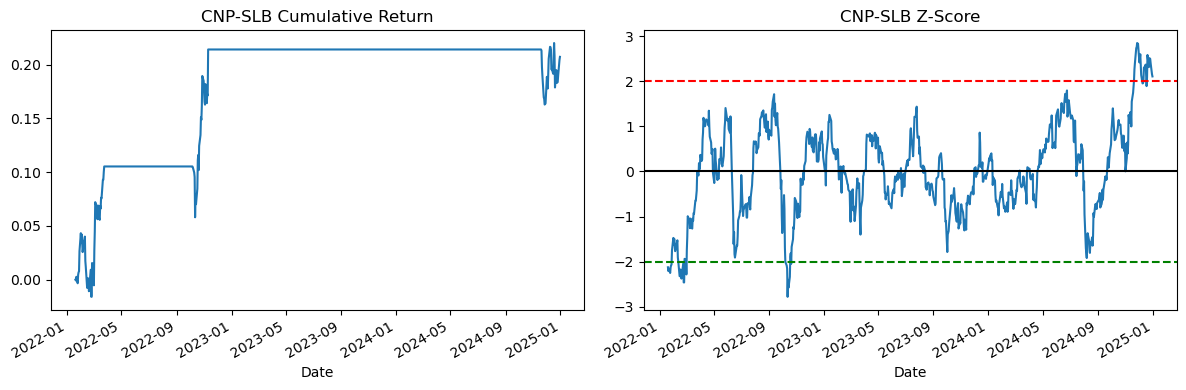

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-SWKS (β=-0.03):
  Trades: 5, Total P&L $6, Return 22.47%
  Sharpe ≈ 0.88


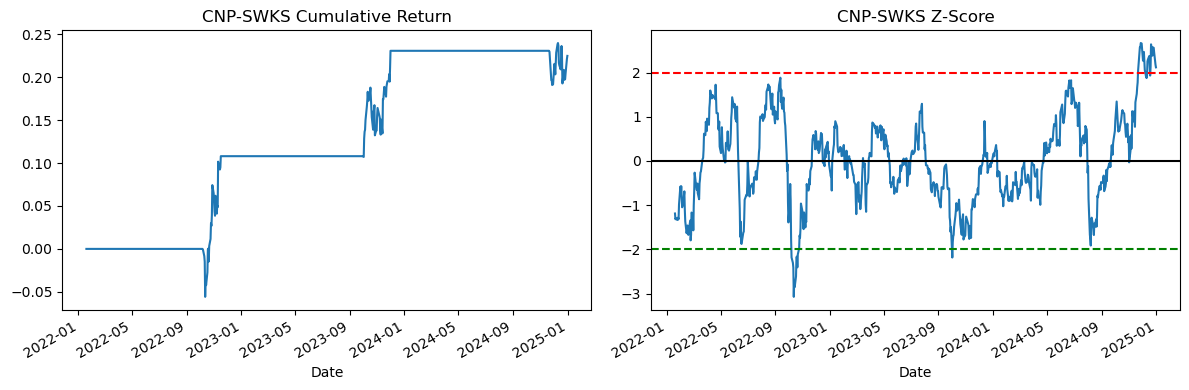

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-TPL (β=0.00):
  Trades: 10, Total P&L $12, Return 39.43%
  Sharpe ≈ 1.65


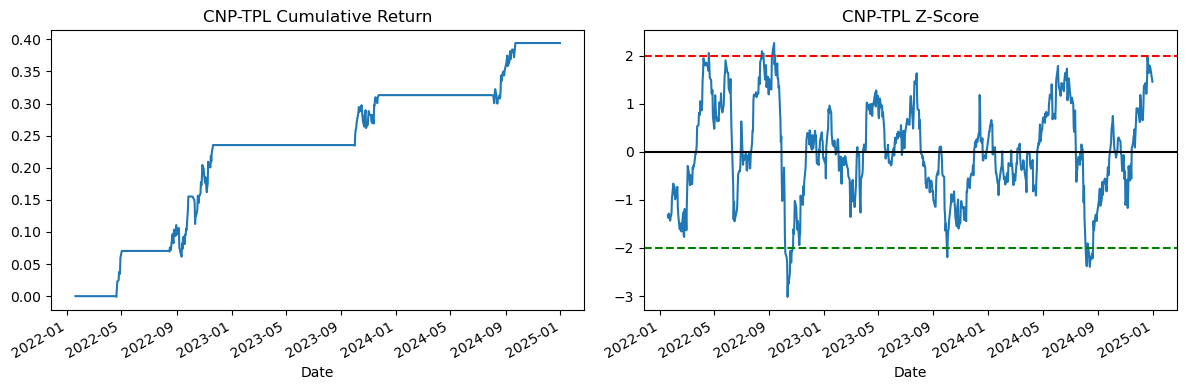

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-VST (β=0.02):
  Trades: 12, Total P&L $14, Return 49.50%
  Sharpe ≈ 2.00


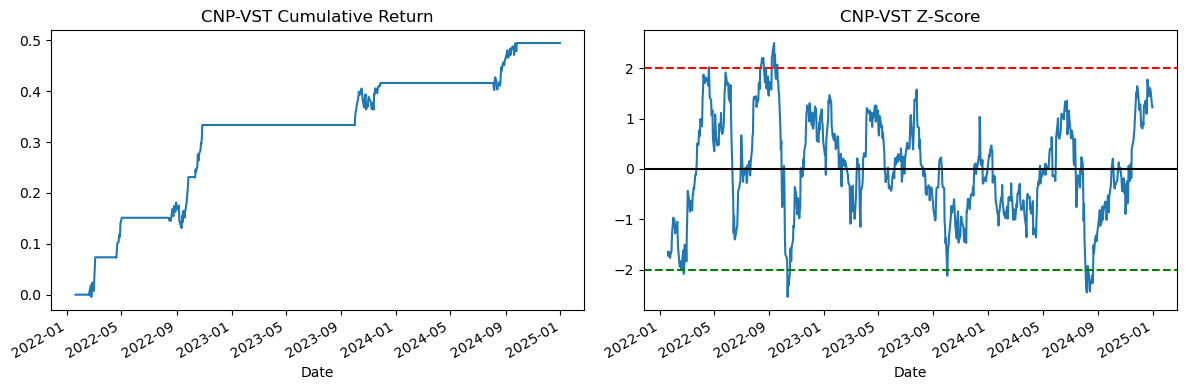

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair CNP-WMB (β=0.10):
  Trades: 8, Total P&L $11, Return 34.68%
  Sharpe ≈ 1.69


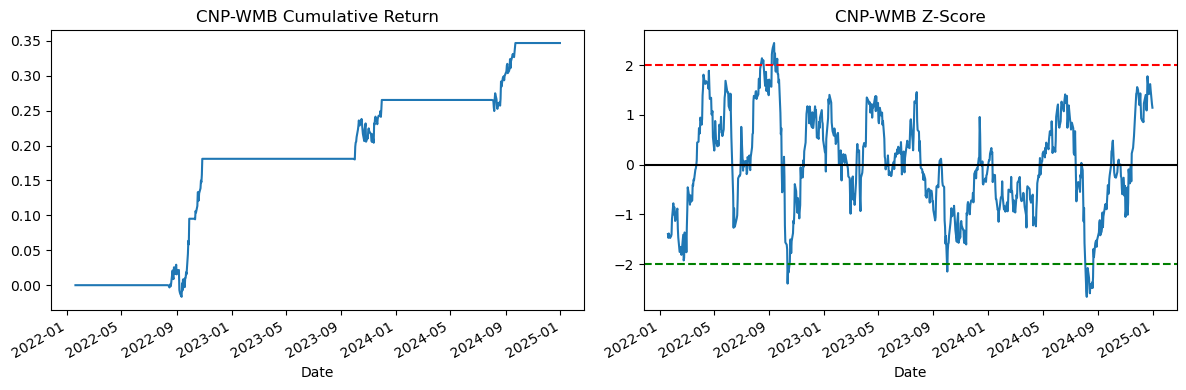

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair DTE-SLB (β=-0.83):
  Trades: 6, Total P&L $37, Return 52.65%
  Sharpe ≈ 1.32


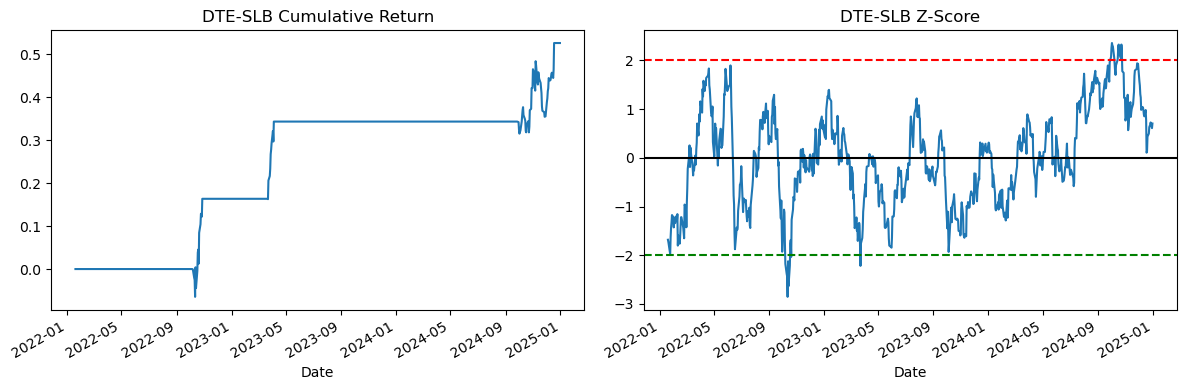


Pair EPAM-FE (β=-8.29):
  Trades: 3, Total P&L $310, Return -1377.14%
  Sharpe ≈ 0.79


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

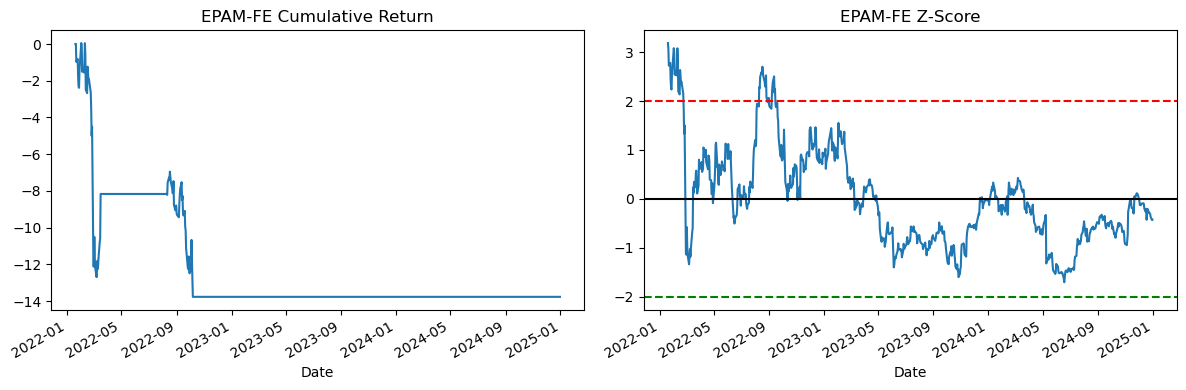

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-KMI (β=-10.47):
  Trades: 4, Total P&L $308, Return 298.32%
  Sharpe ≈ 0.79


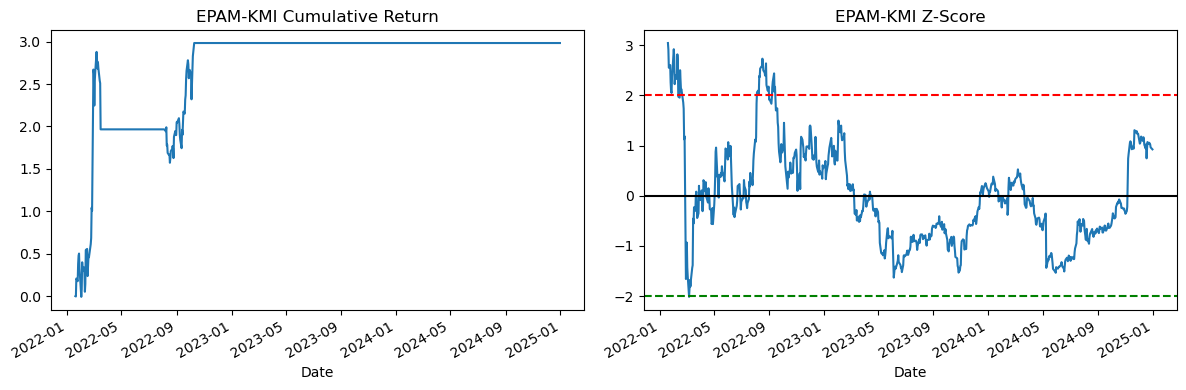

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-NRG (β=-1.85):
  Trades: 4, Total P&L $299, Return 157.74%
  Sharpe ≈ 0.76


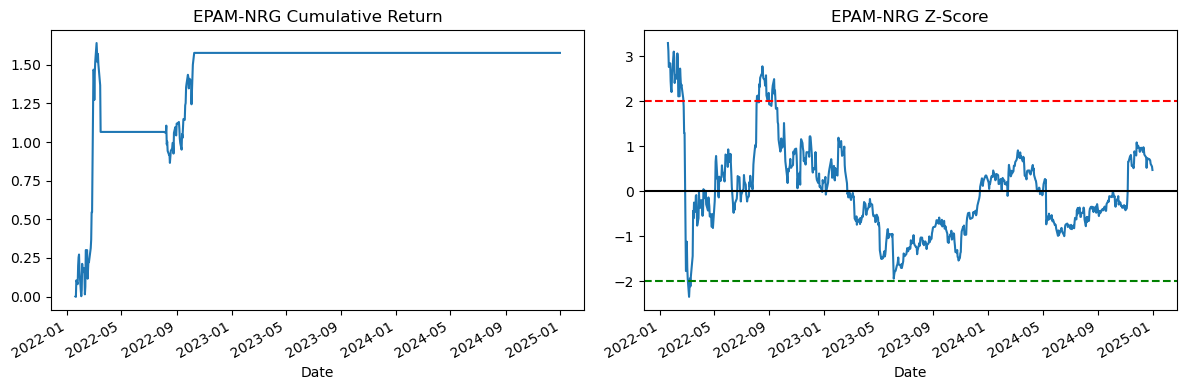

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-PCG (β=-16.24):
  Trades: 6, Total P&L $338, Return 1431.62%
  Sharpe ≈ 1.17


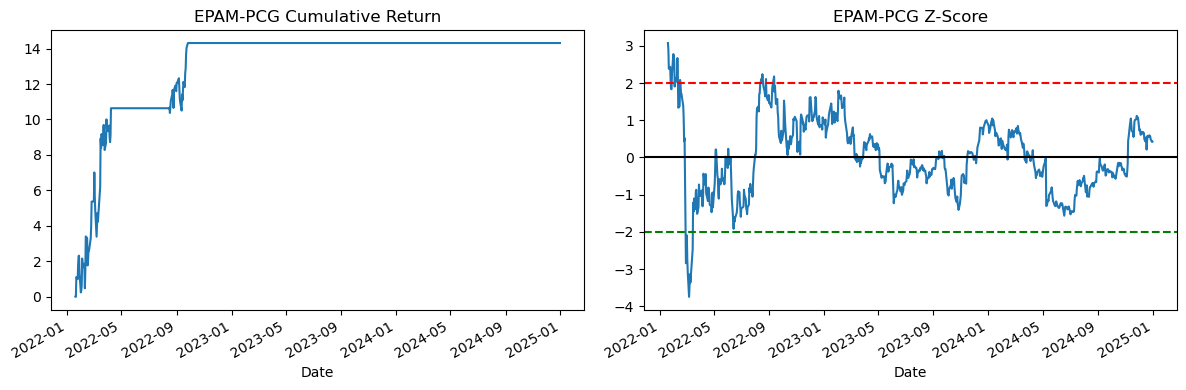

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-PEG (β=-3.60):
  Trades: 4, Total P&L $300, Return 543.68%
  Sharpe ≈ 0.74


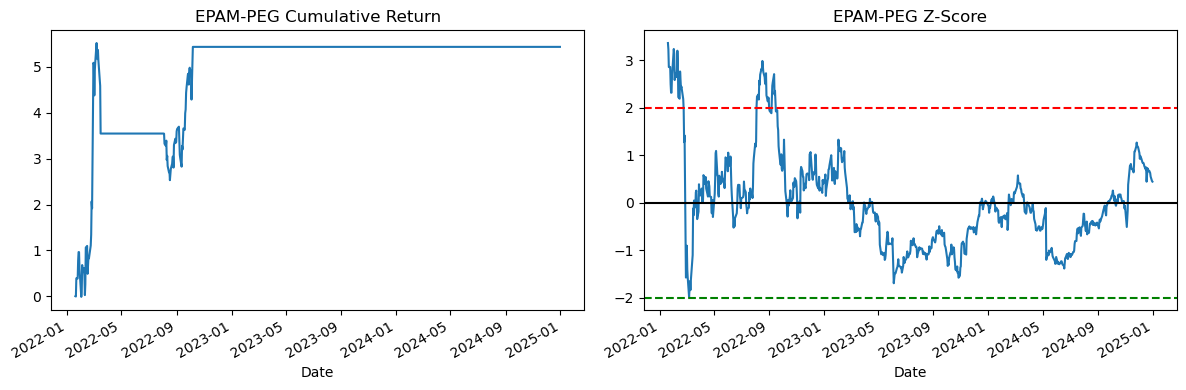

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-PNW (β=-5.55):
  Trades: 3, Total P&L $261, Return -234.07%
  Sharpe ≈ 0.65


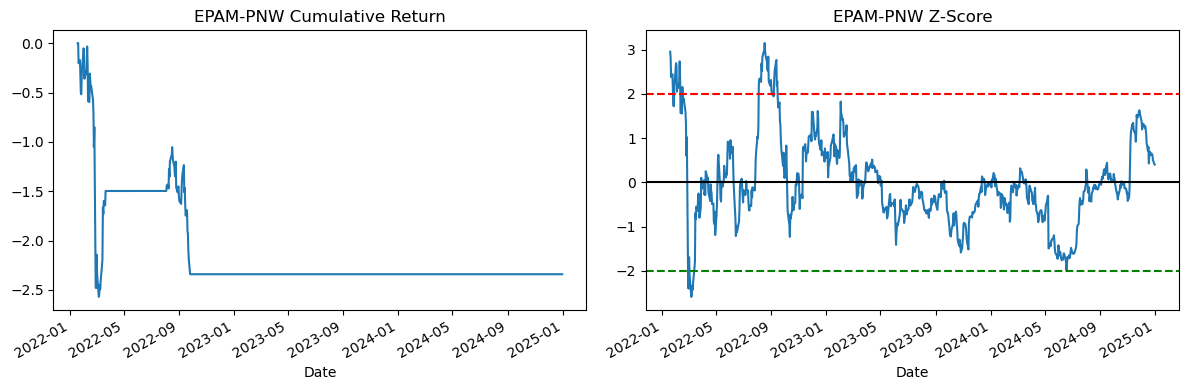

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-PPL (β=-7.29):
  Trades: 4, Total P&L $331, Return 370.30%
  Sharpe ≈ 0.82


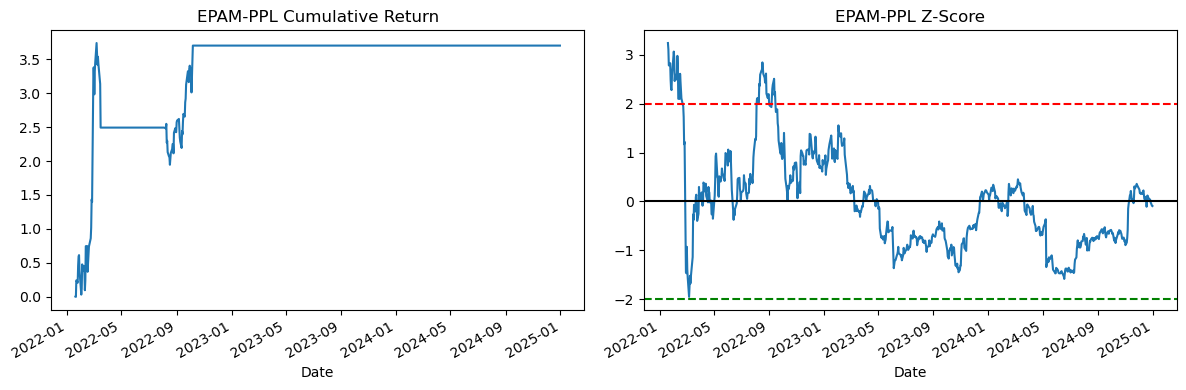

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-SO (β=-4.36):
  Trades: 4, Total P&L $315, Return -1786.89%
  Sharpe ≈ 0.79


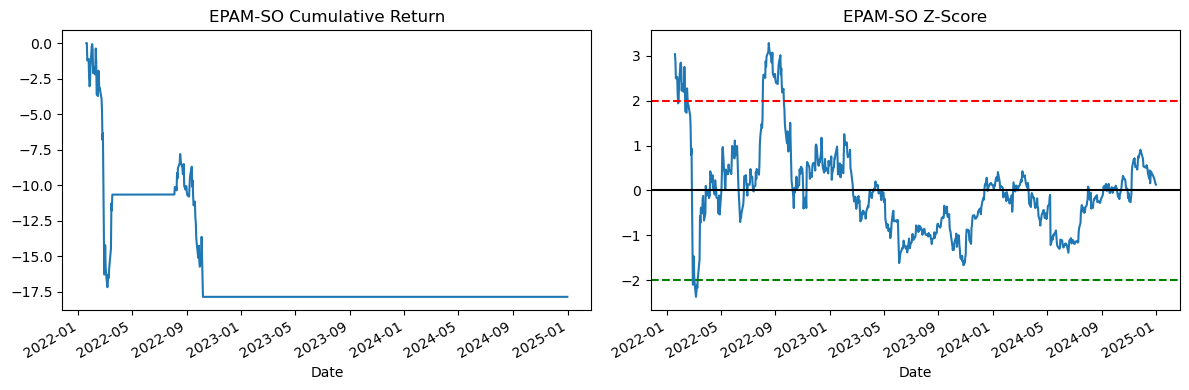

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-VST (β=-1.05):
  Trades: 4, Total P&L $307, Return 132.21%
  Sharpe ≈ 0.78


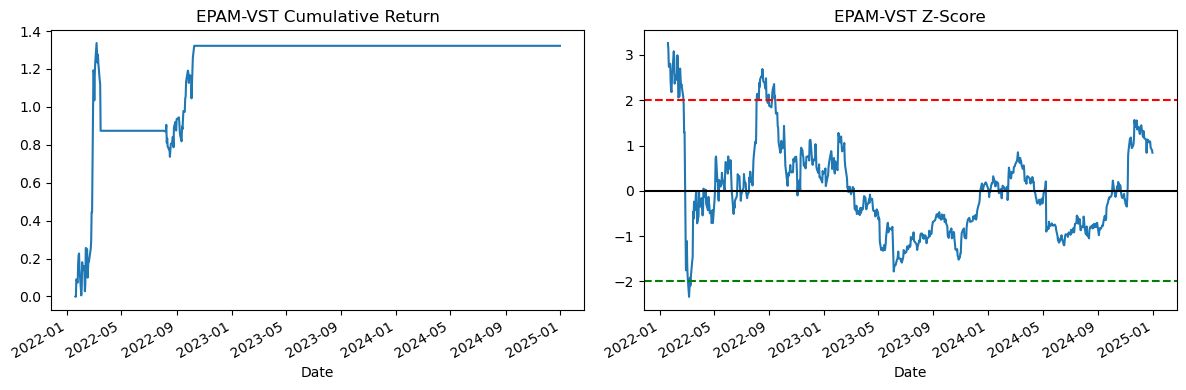

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair EPAM-WMB (β=-5.09):
  Trades: 4, Total P&L $274, Return 246.42%
  Sharpe ≈ 0.69


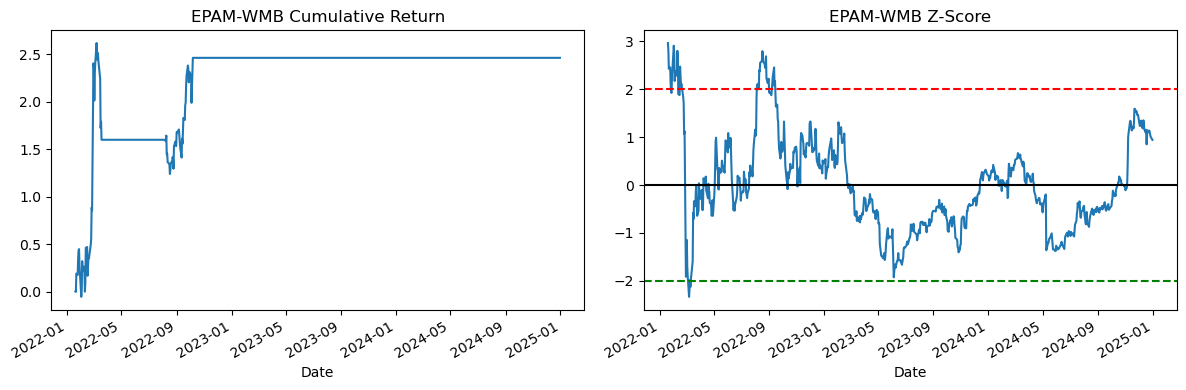

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair EVRG-HAL (β=-0.56):
  Trades: 8, Total P&L $28, Return 79.09%
  Sharpe ≈ 1.53


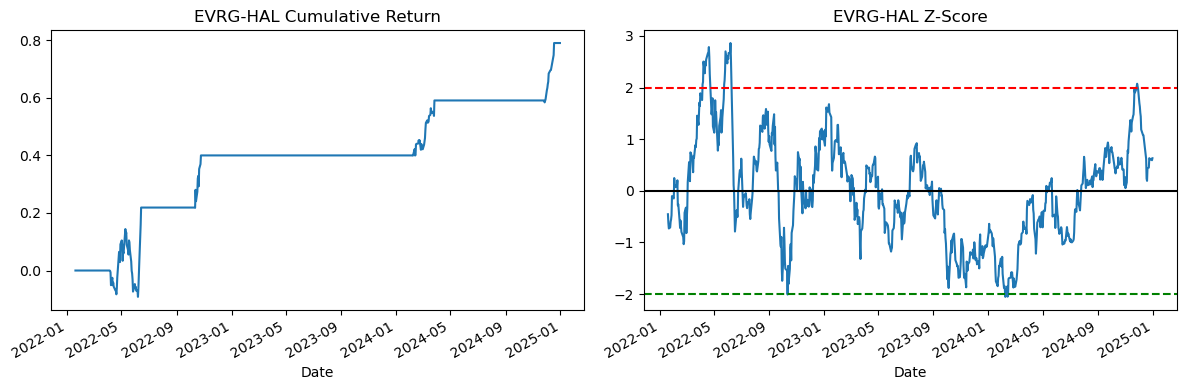

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair EVRG-SLB (β=-0.42):
  Trades: 8, Total P&L $26, Return 75.04%
  Sharpe ≈ 1.95


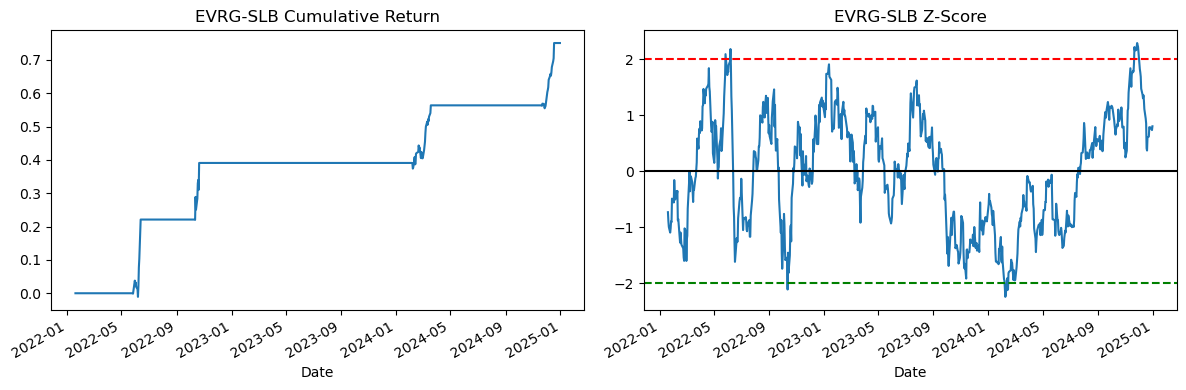

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair HAL-KMI (β=-0.30):
  Trades: 6, Total P&L $19, Return 69.76%
  Sharpe ≈ 1.15


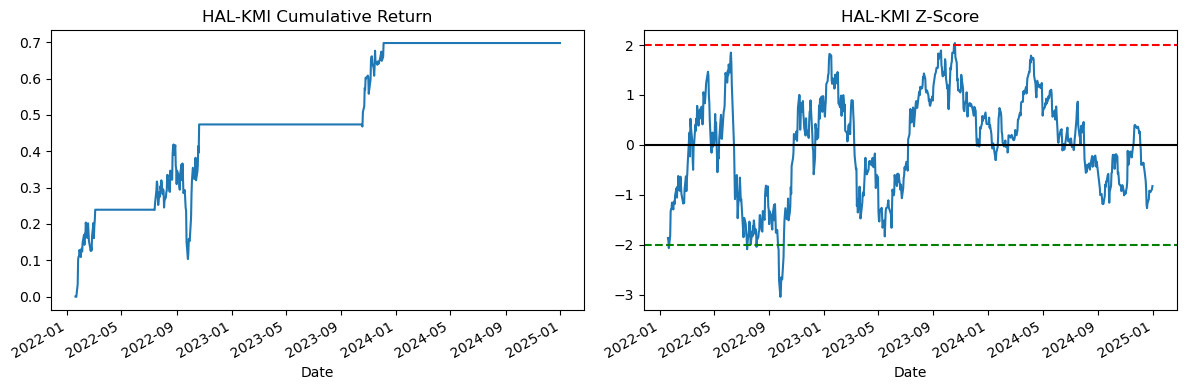

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair HAL-NEE (β=-0.24):
  Trades: 9, Total P&L $28, Return 171.23%
  Sharpe ≈ 1.69


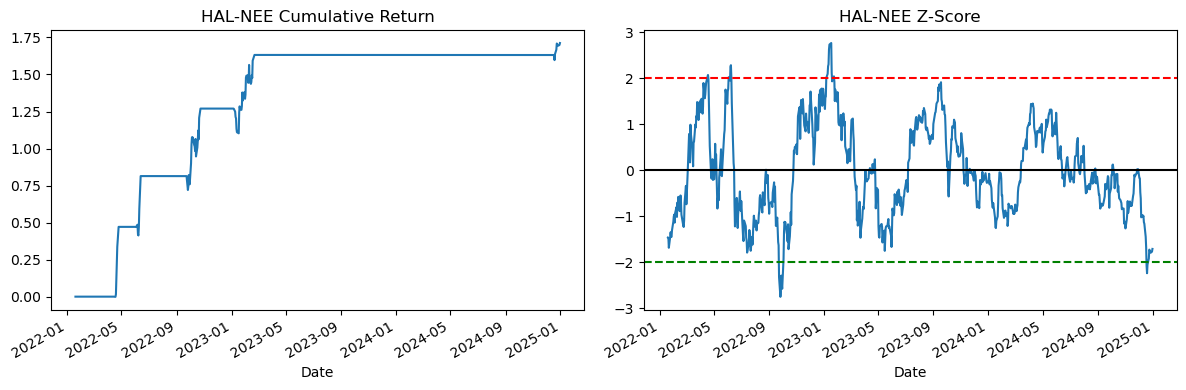

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair HAL-PPL (β=-0.57):
  Trades: 6, Total P&L $20, Return 109.12%
  Sharpe ≈ 1.09


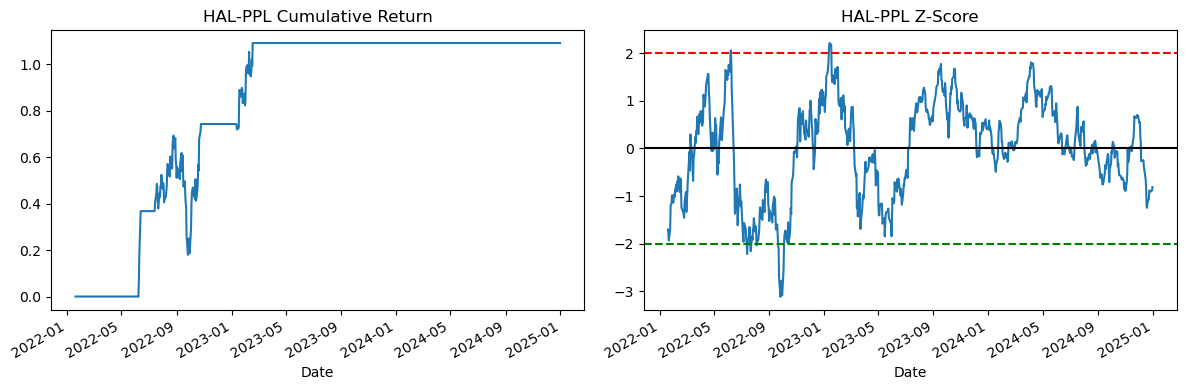

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair HAL-SO (β=-0.17):
  Trades: 6, Total P&L $20, Return 93.79%
  Sharpe ≈ 1.08


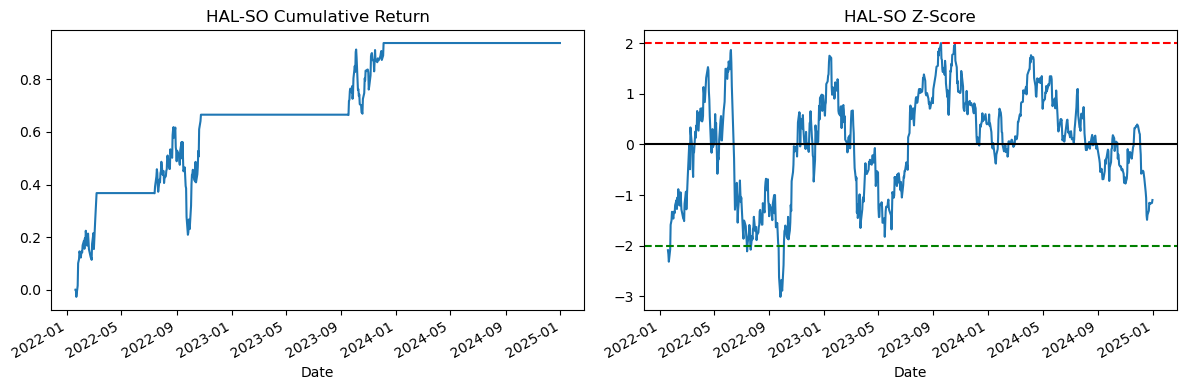


Pair HAL-XEL (β=-0.31):
  Trades: 8, Total P&L $26, Return 186.35%
  Sharpe ≈ 1.62


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

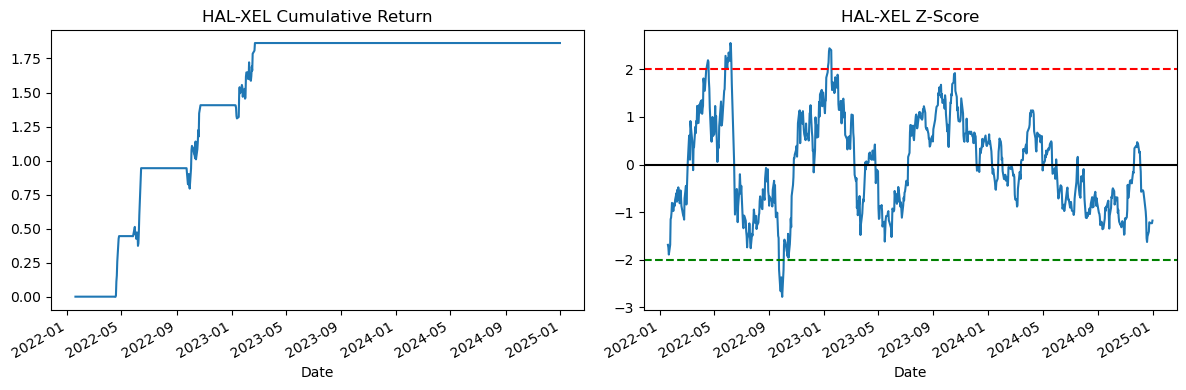

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair PPL-TPL (β=0.01):
  Trades: 6, Total P&L $8, Return 24.74%
  Sharpe ≈ 1.15


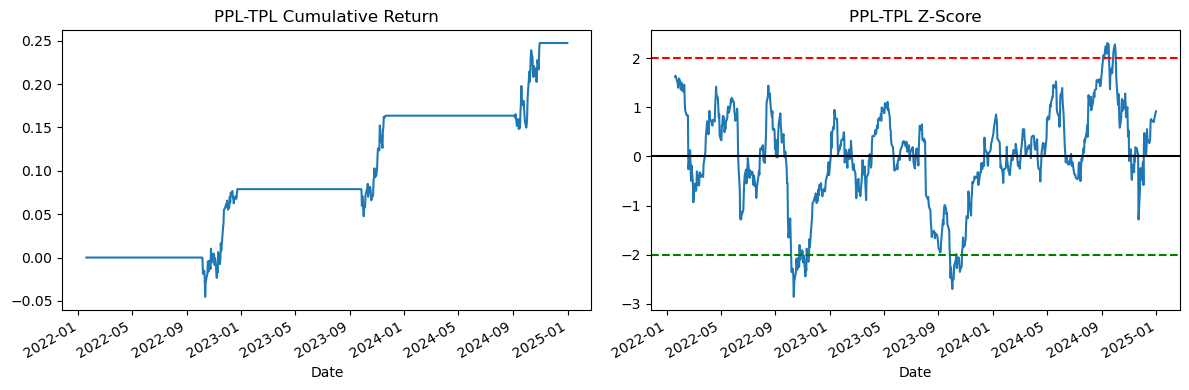


Pair PPL-VST (β=0.06):
  Trades: 6, Total P&L $8, Return 26.57%
  Sharpe ≈ 1.54


/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

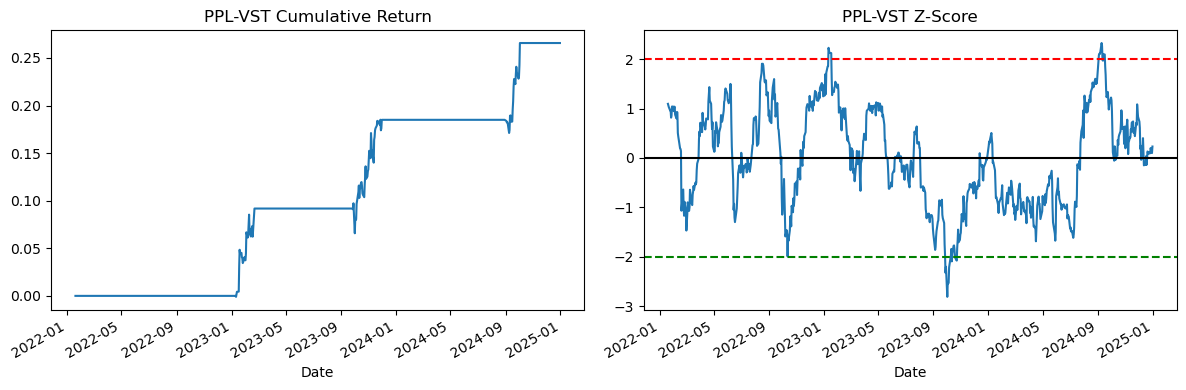

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair SWKS-TDY (β=0.12):
  Trades: 3, Total P&L $30, Return 20.24%
  Sharpe ≈ 0.75


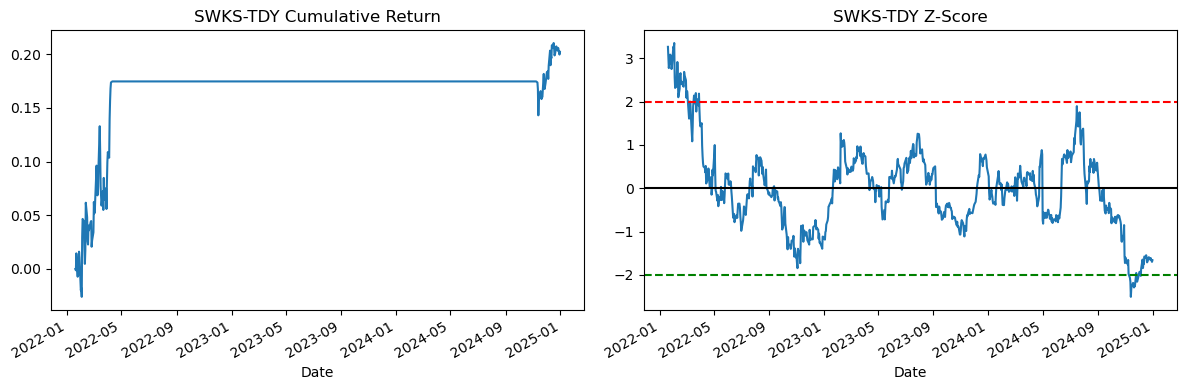

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair SWKS-TPL (β=-0.02):
  Trades: 6, Total P&L $60, Return 71.35%
  Sharpe ≈ 1.02


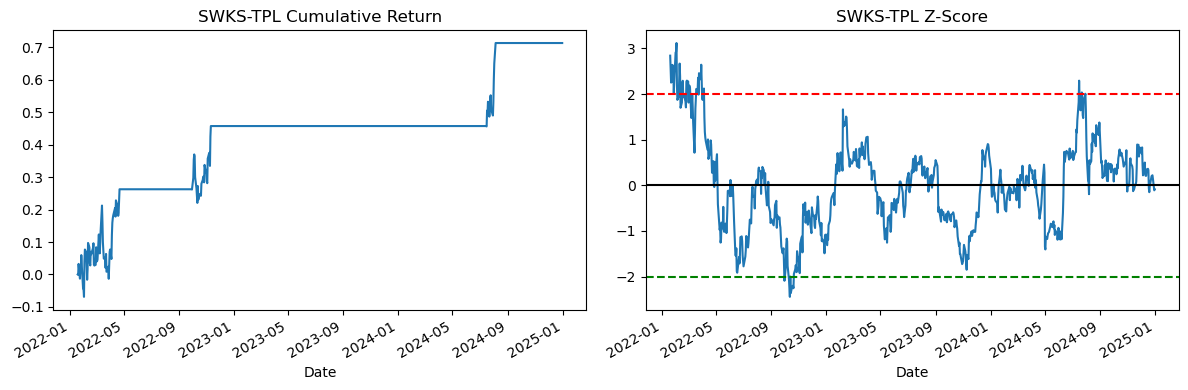

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair SWKS-VST (β=-0.07):
  Trades: 4, Total P&L $42, Return 44.48%
  Sharpe ≈ 0.76


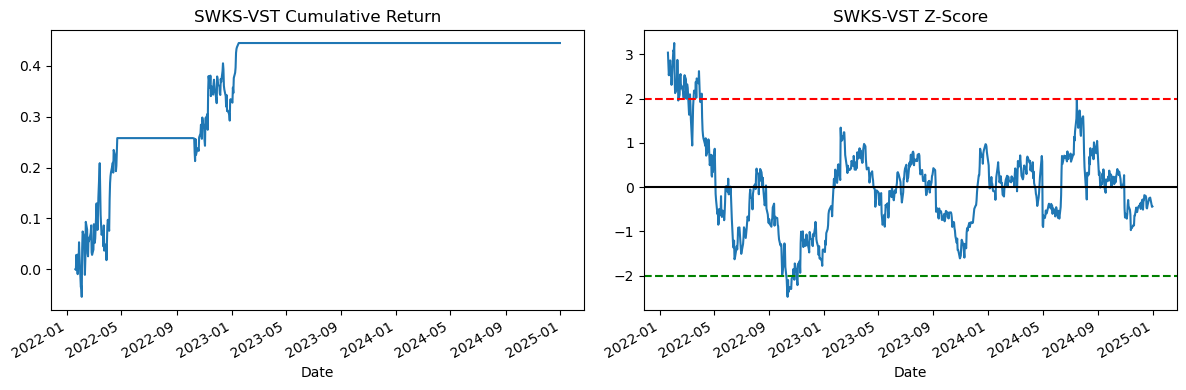

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair SWKS-WMB (β=-0.37):
  Trades: 4, Total P&L $42, Return 49.41%
  Sharpe ≈ 0.72


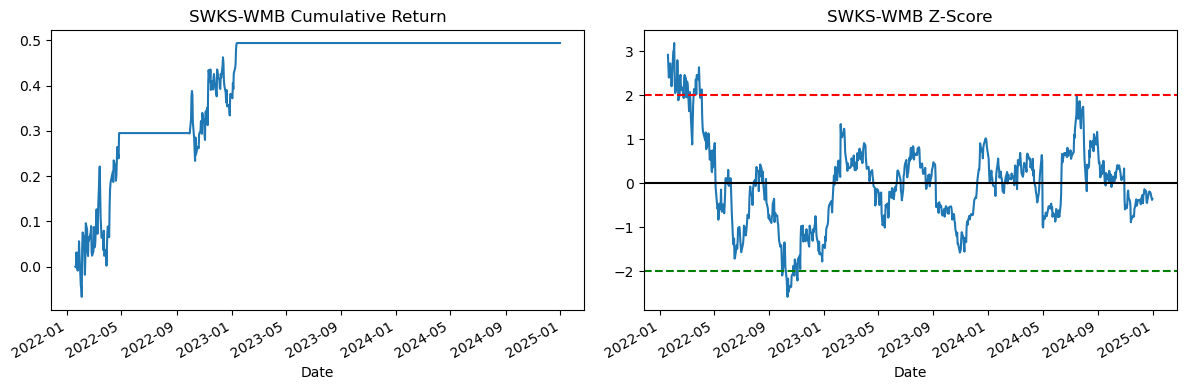

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(z[t]) < exit_z:
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Pair SWKS-XEL (β=-0.05):
  Trades: 4, Total P&L $46, Return 48.18%
  Sharpe ≈ 0.82


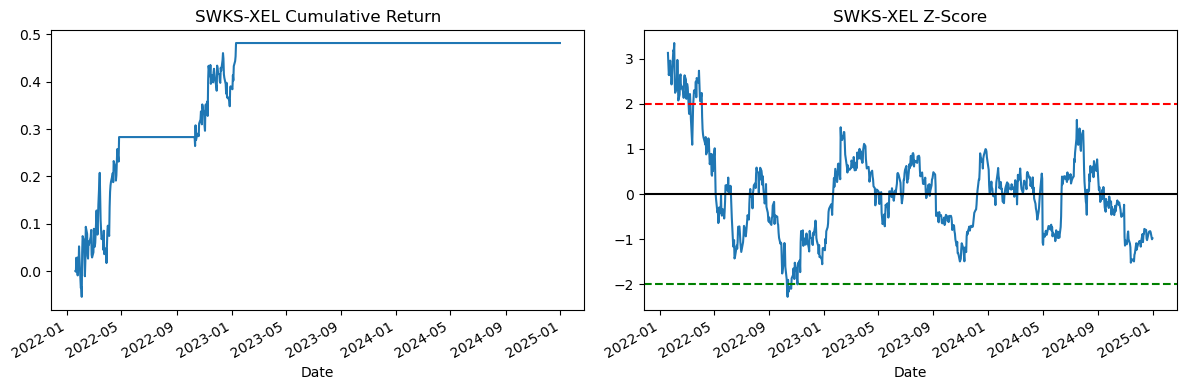

/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[t] >  entry_z: pos[t] = -1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[t] < -entry_z: pos[t] = +1
/var/folders/z8/lprld2kj00j12npqpk_410yr0000gn/T/ipykernel_15923/3264071145.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `


Pair VST-WMB (β=4.63):
  Trades: 6, Total P&L $50, Return 24.78%
  Sharpe ≈ 1.02


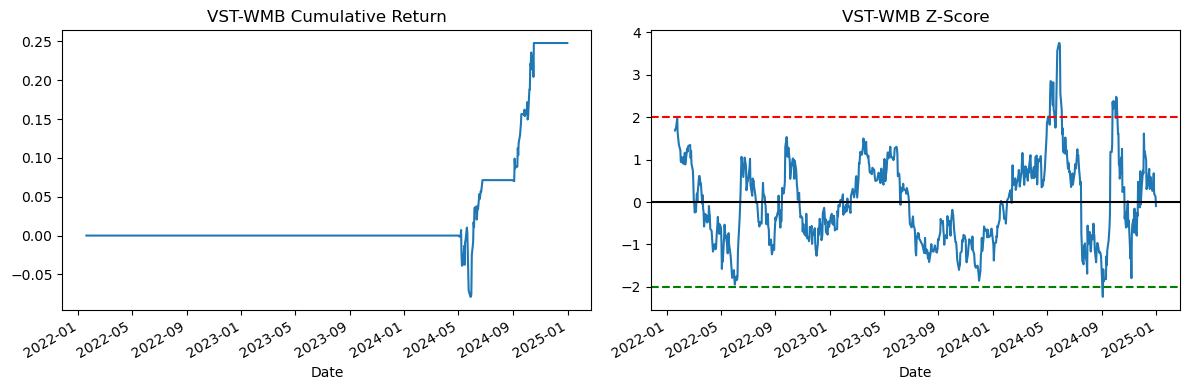

In [4]:
# 3. Run backtest for each pair & plot
for pair in coint_pairs:
    A, B, beta = pair["A"], pair["B"], pair["beta"]
    bt = backtest_pair(prices, A, B, beta, entry_z, exit_z, cost_rate)

    # summary stats
    total_pnl = bt["CumPnL"].iloc[-1]
    total_ret = bt["CumReturn"].iloc[-1]
    num_trades = (bt["Cost"]>0).sum()
    sharpe = bt["PnL_net"].mean() / bt["PnL_net"].std() * np.sqrt(252)

    print(f"\nPair {A}-{B} (β={beta:.2f}):")
    print(f"  Trades: {num_trades}, Total P&L ${total_pnl:,.0f}, Return {100*total_ret:.2f}%")
    print(f"  Sharpe ≈ {sharpe:.2f}")

    # plot cumulative return
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    bt["CumReturn"].plot(ax=ax[0], title=f"{A}-{B} Cumulative Return")
    bt["Z"].plot(ax=ax[1], title=f"{A}-{B} Z-Score")
    ax[1].axhline(entry_z, color='r', ls='--')
    ax[1].axhline(-entry_z, color='g', ls='--')
    ax[1].axhline(0, color='k')
    plt.tight_layout()
    plt.show()
